# Generate correlation heatmaps

We use Pearson's correlation to derive scores between wells.

In [1]:
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np

from pycytominer import aggregate

print(pathlib.Path.cwd())

/home/jenna/predicting_cardiac_fibrosis_etiologies/4.EDA


In [2]:
# Set plate to process
plate_to_process = "redo"  # options: "redo" and "original"

# Set output directory for figures based on plate to process
if plate_to_process == "redo":
    output_dir = pathlib.Path("./figures/heatmaps/redo_DMSO_plate")
    output_dir.mkdir(parents=True, exist_ok=True)
elif plate_to_process == "original":
    output_dir = pathlib.Path("./figures/heatmaps/original_DMSO_plate")
    output_dir.mkdir(parents=True, exist_ok=True)

# Build a resolved base directory for repository (one level up from current notebook)
base_dir = pathlib.Path.cwd().parent.resolve()

# Directory containing single-cell feature-selected parquet files
sc_dir = base_dir / "." / "3.preprocessing_profiles" / "data" / "single_cell_profiles"

if plate_to_process == "redo":
    fname = "CARD-CelIns-CX7_251110170001_sc_feature_selected.parquet"
elif plate_to_process == "original":
    fname = "CARD-CelIns-CX7_251023130003_sc_feature_selected.parquet"
else:
    raise ValueError(f"Unknown plate_to_process: {plate_to_process}")

# Construct full path and ensure it exists (resolve with strict to raise if missing)
try:
    data_path = (sc_dir / fname).resolve(strict=True)
except Exception as e:
    raise FileNotFoundError(f"Could not resolve path for {fname} in {sc_dir}: {e}")

# Load parquet
single_cell_data = pd.read_parquet(data_path)
print("Loaded single-cell data from:", data_path)

Loaded single-cell data from: /home/jenna/predicting_cardiac_fibrosis_etiologies/3.preprocessing_profiles/data/single_cell_profiles/CARD-CelIns-CX7_251110170001_sc_feature_selected.parquet


In [3]:
# Print the number of single-cells across heart #s
print(single_cell_data["Metadata_heart_number"].value_counts())

Metadata_heart_number
2     2501
46    2331
47    1421
23     994
25     861
7      744
Name: count, dtype: int64


In [4]:
# Aggregate to well-level using median
aggregate_df = aggregate(
    population_df=single_cell_data,
    operation="median",
    strata=[
        "Metadata_Plate",
        "Metadata_Well",
        "Metadata_heart_number",
        "Metadata_treatment",
        "Metadata_cell_type",
    ],
)

# Print shape and head
print("Aggregated well-level data shape:", aggregate_df.shape)
aggregate_df.head()

Aggregated well-level data shape: (56, 991)


,Metadata_Plate,Metadata_Well,Metadata_heart_number,Metadata_treatment,Metadata_cell_type,Cytoplasm_AreaShape_Eccentricity,Cytoplasm_AreaShape_MajorAxisLength,Cytoplasm_AreaShape_MaximumRadius,Cytoplasm_AreaShape_Orientation,Cytoplasm_AreaShape_Zernike_2_0,...,Nuclei_Texture_InfoMeas2_PM_3_02_256,Nuclei_Texture_InfoMeas2_PM_3_03_256,Nuclei_Texture_InverseDifferenceMoment_ER_3_03_256,Nuclei_Texture_InverseDifferenceMoment_Mitochondria_3_00_256,Nuclei_Texture_InverseDifferenceMoment_Mitochondria_3_02_256,Nuclei_Texture_InverseDifferenceMoment_PM_3_00_256,Nuclei_Texture_SumVariance_ER_3_01_256,Nuclei_Texture_SumVariance_Hoechst_3_03_256,Nuclei_Texture_SumVariance_Mitochondria_3_03_256,Nuclei_Texture_SumVariance_PM_3_01_256
0,CARD-CelIns-CX7_251110170001,B02,2,DMSO,Healthy,0.281820,-0.085447,-0.256874,-0.195555,-0.211256,...,0.137823,0.100847,-0.074907,-0.357352,-0.359320,-0.431150,-0.180532,-0.149953,-0.159862,-0.096577
1,CARD-CelIns-CX7_251110170001,B03,7,DMSO,Healthy,0.383188,0.454547,0.331640,0.168882,-0.116449,...,0.055131,0.108618,0.056650,0.225138,0.213177,-0.705504,-0.289636,-0.168475,-0.341380,-0.057371
2,CARD-CelIns-CX7_251110170001,B04,2,None,Healthy,0.221719,-0.111729,-0.235859,-0.045839,-0.194420,...,-0.052560,0.041883,-0.003850,-0.069145,-0.064935,-0.657217,-0.251508,-0.128058,-0.280574,-0.070661
3,CARD-CelIns-CX7_251110170001,B05,23,DMSO,Failing,-0.203033,0.478895,1.227796,-0.205264,0.644527,...,0.194852,0.114394,0.182121,0.388947,0.411885,-0.972852,-0.312469,-0.238558,-0.376559,0.015324
4,CARD-CelIns-CX7_251110170001,B06,25,DMSO,Failing,-0.003511,0.106069,0.648430,0.024499,0.433310,...,0.058155,0.091552,0.144924,0.694249,0.673955,-1.008211,-0.254812,-0.221718,-0.416632,0.008445


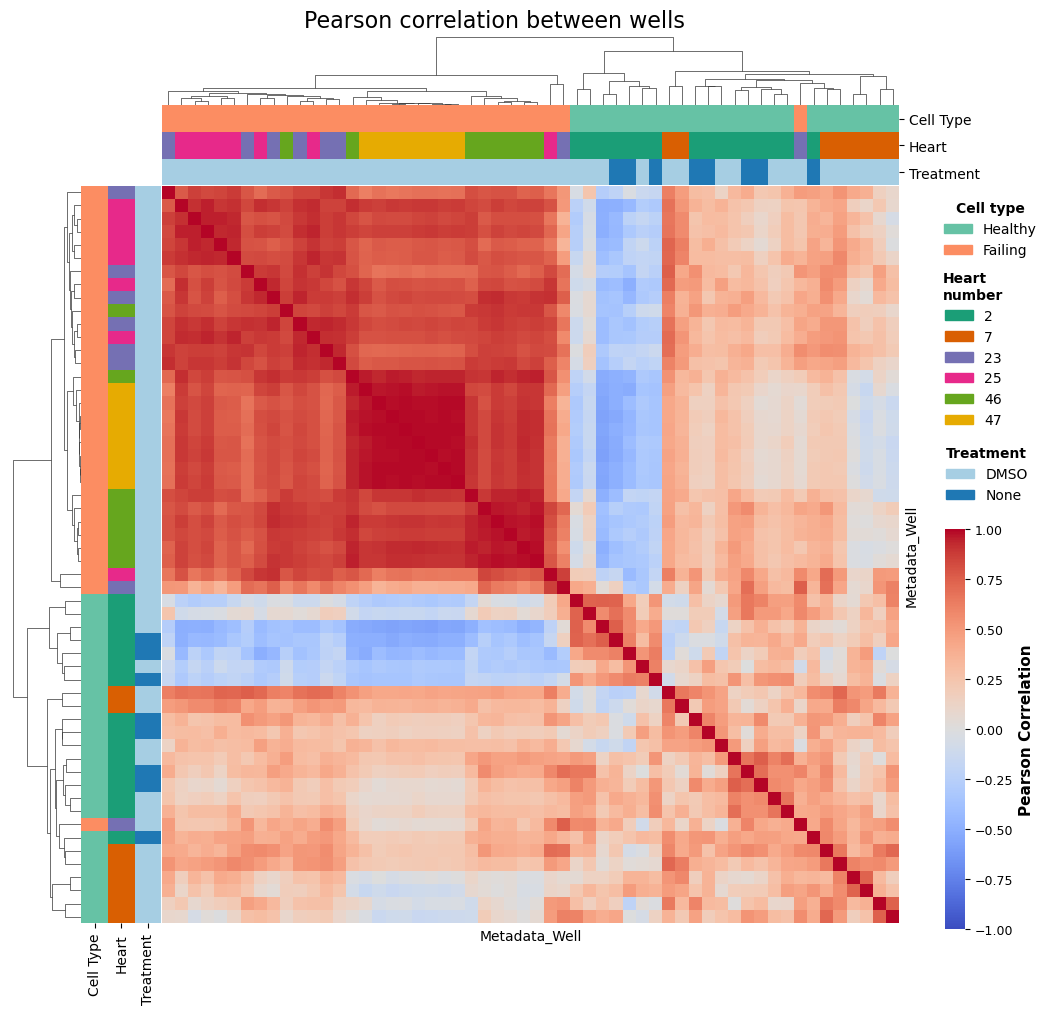

In [5]:
# --- Prepare correlation matrix ---
feature_cols = [col for col in aggregate_df.columns if not col.startswith("Metadata_")]
well_feature_df = aggregate_df.set_index("Metadata_Well")[feature_cols]
well_corr_matrix = well_feature_df.T.corr()

# --- Create metadata color annotations ---
meta_df = aggregate_df.set_index("Metadata_Well")[
    ["Metadata_cell_type", "Metadata_heart_number", "Metadata_treatment"]
]

# Define palettes
cell_type_palette = sns.color_palette(
    "Set2", n_colors=meta_df["Metadata_cell_type"].nunique()
)
cell_type_colors = dict(zip(meta_df["Metadata_cell_type"].unique(), cell_type_palette))

heart_palette = sns.color_palette(
    "Dark2", n_colors=meta_df["Metadata_heart_number"].nunique()
)
heart_colors = dict(zip(meta_df["Metadata_heart_number"].unique(), heart_palette))

treatment_palette = sns.color_palette(
    "Paired", n_colors=meta_df["Metadata_treatment"].nunique()
)
treatment_colors = dict(zip(meta_df["Metadata_treatment"].unique(), treatment_palette))

# --- Combine color annotations ---
row_colors = pd.DataFrame(
    {
        "Cell Type": meta_df["Metadata_cell_type"].map(cell_type_colors),
        "Heart": meta_df["Metadata_heart_number"].map(heart_colors),
        "Treatment": meta_df["Metadata_treatment"].map(treatment_colors),
    }
).reindex(well_corr_matrix.index)

# --- Plot clustermap ---
g = sns.clustermap(
    well_corr_matrix,
    cmap="coolwarm",
    center=0,
    row_colors=row_colors,
    col_colors=row_colors,
    figsize=(10, 10),
    linewidths=0,
    xticklabels=False,
    yticklabels=False,
    dendrogram_ratio=(0.08, 0.08),
    cbar_pos=(0.95, 0.09, 0.02, 0.4),
    vmin=-1,  # <--- set min scale
    vmax=1,  # <--- set max scale
)

g.fig.suptitle("Pearson correlation between wells", y=1.01, fontsize=16)

# --- Add legends for each metadata type ---
cell_patches = [mpatches.Patch(color=c, label=ct) for ct, c in cell_type_colors.items()]
heart_patches = [mpatches.Patch(color=c, label=h) for h, c in heart_colors.items()]
treat_patches = [mpatches.Patch(color=c, label=t) for t, c in treatment_colors.items()]

leg1 = g.fig.legend(
    handles=cell_patches,
    title="Cell type",
    loc="upper right",
    bbox_to_anchor=(1.054, 0.83),
    frameon=False,
)
leg2 = g.fig.legend(
    handles=heart_patches,
    title="Heart\nnumber",
    loc="upper right",
    bbox_to_anchor=(1.021, 0.76),
    frameon=False,
)
leg3 = g.fig.legend(
    handles=treat_patches,
    title="Treatment",
    loc="upper right",
    bbox_to_anchor=(1.045, 0.585),
    frameon=False,
)

plt.setp(leg1.get_title(), fontsize=10, fontweight="bold")
plt.setp(leg2.get_title(), fontsize=10, fontweight="bold")
plt.setp(leg3.get_title(), fontsize=10, fontweight="bold")

# --- Label the correlation colorbar ---
cbar = g.ax_heatmap.collections[0].colorbar
cbar.set_label("Pearson Correlation", fontsize=11, fontweight="bold")
cbar.ax.tick_params(labelsize=9)

plt.savefig(
    f"{output_dir}/well_correlation_clustermap_{plate_to_process}.png",
    bbox_inches="tight",
    dpi=300,
)
plt.show()

In [6]:
# --- Split by heart number ---
for heart_num, heart_df in aggregate_df.groupby("Metadata_heart_number"):
    if heart_num == 2:
        # --- Split heart #2 further by treatment ---
        for treatment, treat_df in heart_df.groupby("Metadata_treatment"):
            feature_cols = [
                col for col in treat_df.columns if not col.startswith("Metadata_")
            ]
            well_feature_df = treat_df.set_index("Metadata_Well")[feature_cols]
            well_corr_matrix = well_feature_df.T.corr()

            # Make sure indices match as strings
            well_corr_matrix.index = well_corr_matrix.index.astype(str)
            well_corr_matrix.columns = well_corr_matrix.columns.astype(str)
            treat_df["Metadata_Well"] = treat_df["Metadata_Well"].astype(str)

            # Map colors by well
            well_palette = sns.color_palette(
                "Dark2", n_colors=treat_df["Metadata_Well"].nunique()
            )
            well_colors = dict(
                zip(sorted(treat_df["Metadata_Well"].unique()), well_palette)
            )

            # --- FIXED: proper one-to-one color mapping ---
            row_colors_df = pd.Series(
                [well_colors[w] for w in well_corr_matrix.index],
                index=well_corr_matrix.index,
                name="Well",
            )
            col_colors_series = pd.Series(
                [well_colors[w] for w in well_corr_matrix.columns],
                index=well_corr_matrix.columns,
                name="Well",
            )

            # --- Plot clustermap ---
            g = sns.clustermap(
                well_corr_matrix,
                cmap="coolwarm",
                center=0,
                row_colors=row_colors_df,
                col_colors=col_colors_series,
                figsize=(10, 10),
                linewidths=0,
                xticklabels=False,
                yticklabels=False,
                dendrogram_ratio=(0.08, 0.08),
                cbar_pos=(0.98, 0.20, 0.02, 0.4),
                vmin=-1,  # <--- set min scale
                vmax=1,  # <--- set max scale
            )

            g.fig.suptitle(
                f"Pearson correlation between wells — Heart {heart_num}, Treatment {treatment}",
                y=1.01,
                fontsize=16,
            )

            # Legend for wells
            patches = [mpatches.Patch(color=c, label=w) for w, c in well_colors.items()]
            leg = g.fig.legend(
                handles=patches,
                title="Well",
                loc="upper right",
                bbox_to_anchor=(1.06, 0.85),
                frameon=False,
            )
            plt.setp(leg.get_title(), fontsize=10, fontweight="bold")

            # Label colorbar
            cbar = g.ax_heatmap.collections[0].colorbar
            cbar.set_label("Pearson Correlation", fontsize=11, fontweight="bold")
            cbar.ax.tick_params(labelsize=9)

            plt.savefig(
                f"well_correlation_clustermap_{heart_num}_{treatment}_{plate_to_process}.png",
                bbox_inches="tight",
                dpi=300,
            )

            plt.close()

    else:
        # --- Normal hearts ---
        feature_cols = [
            col for col in heart_df.columns if not col.startswith("Metadata_")
        ]
        well_feature_df = heart_df.set_index("Metadata_Well")[feature_cols]
        well_corr_matrix = well_feature_df.T.corr()

        # Match index dtypes
        well_corr_matrix.index = well_corr_matrix.index.astype(str)
        well_corr_matrix.columns = well_corr_matrix.columns.astype(str)
        heart_df["Metadata_Well"] = heart_df["Metadata_Well"].astype(str)

        well_palette = sns.color_palette(
            "Dark2", n_colors=heart_df["Metadata_Well"].nunique()
        )
        well_colors = dict(
            zip(sorted(heart_df["Metadata_Well"].unique()), well_palette)
        )

        # --- One-to-one color mapping ---
        row_colors_df = pd.Series(
            [well_colors[w] for w in well_corr_matrix.index],
            index=well_corr_matrix.index,
            name="Well",
        )
        col_colors_series = pd.Series(
            [well_colors[w] for w in well_corr_matrix.columns],
            index=well_corr_matrix.columns,
            name="Well",
        )

        # --- Plot clustermap ---
        g = sns.clustermap(
            well_corr_matrix,
            cmap="coolwarm",
            center=0,
            row_colors=row_colors_df,
            col_colors=col_colors_series,
            figsize=(10, 10),
            linewidths=0,
            xticklabels=False,
            yticklabels=False,
            dendrogram_ratio=(0.08, 0.08),
            cbar_pos=(0.98, 0.20, 0.02, 0.4),
            vmin=-1,  # <--- set min scale
            vmax=1,  # <--- set max scale
        )

        g.fig.suptitle(
            f"Pearson correlation between wells — Heart {heart_num}",
            y=1.01,
            fontsize=16,
        )

        patches = [mpatches.Patch(color=c, label=w) for w, c in well_colors.items()]
        leg = g.fig.legend(
            handles=patches,
            title="Well",
            loc="upper right",
            bbox_to_anchor=(1.06, 0.85),
            frameon=False,
        )
        plt.setp(leg.get_title(), fontsize=10, fontweight="bold")

        cbar = g.ax_heatmap.collections[0].colorbar
        cbar.set_label("Pearson Correlation", fontsize=11, fontweight="bold")
        cbar.ax.tick_params(labelsize=9)

        plt.savefig(
            f"{output_dir}/well_correlation_clustermap_{heart_num}_{plate_to_process}.png",
            bbox_inches="tight",
            dpi=300,
        )

        plt.close()

## Generate single-cell correlation heatmap for only heart #23

In [7]:
# --- Loop through all hearts ---
for heart_num, heart_df in single_cell_data.groupby("Metadata_heart_number"):
    print(f"Processing Heart {heart_num}, shape: {heart_df.shape}")

    # --- For heart #2, split by treatment ---
    if heart_num == 2:
        for treatment, treat_df in heart_df.groupby("Metadata_treatment"):
            print(f"  Treatment: {treatment}, shape: {treat_df.shape}")

            # Select feature columns
            feature_cols = [
                col for col in treat_df.columns if not col.startswith("Metadata_")
            ]
            cell_feature_df = treat_df[feature_cols]

            # Compute Pearson correlation
            cell_corr_matrix = cell_feature_df.T.corr()

            # Map colors by well
            wells = treat_df["Metadata_Well"].astype(str)
            well_palette = sns.color_palette("Dark2", n_colors=wells.nunique())
            well_colors = dict(zip(sorted(wells.unique()), well_palette))
            row_colors = pd.Series(
                [well_colors[w] for w in wells],
                index=cell_corr_matrix.index,
                name="Well",
            )
            col_colors = pd.Series(
                [well_colors[w] for w in wells],
                index=cell_corr_matrix.columns,
                name="Well",
            )

            # Plot clustermap
            g = sns.clustermap(
                cell_corr_matrix,
                cmap="coolwarm",
                center=0,
                row_colors=row_colors,
                col_colors=col_colors,
                figsize=(12, 12),
                linewidths=0,
                xticklabels=False,
                yticklabels=False,
                dendrogram_ratio=(0.008, 0.008),
                cbar_pos=(0.98, 0.25, 0.02, 0.4),
                vmin=-1,
                vmax=1,
                row_cluster=False,
                col_cluster=False,
            )

            g.fig.suptitle(
                f"Pearson correlation — Heart 2 — Treatment {treatment}",
                y=1.0,
                fontsize=16,
            )

            # Add legend for wells
            well_patches = [
                mpatches.Patch(color=c, label=w) for w, c in well_colors.items()
            ]
            leg = g.fig.legend(
                handles=well_patches,
                title="Well",
                loc="upper right",
                bbox_to_anchor=(1.047, 0.85),
                frameon=False,
            )
            plt.setp(leg.get_title(), fontsize=10, fontweight="bold")

            # Label colorbar
            cbar = g.ax_heatmap.collections[0].colorbar
            cbar.set_label("Pearson Correlation", fontsize=11, fontweight="bold")
            cbar.ax.tick_params(labelsize=9)

            plt.savefig(
                f"{output_dir}/sc_correlation_clustermap_Heart2_{treatment}_{plate_to_process}.png",
                bbox_inches="tight",
                dpi=300,
            )
            plt.close()

    # --- For all other hearts ---
    else:
        # Select feature columns
        feature_cols = [
            col for col in heart_df.columns if not col.startswith("Metadata_")
        ]
        cell_feature_df = heart_df[feature_cols]

        # Compute Pearson correlation
        cell_corr_matrix = cell_feature_df.T.corr()

        # Map colors by well
        wells = heart_df["Metadata_Well"].astype(str)
        well_palette = sns.color_palette("Dark2", n_colors=wells.nunique())
        well_colors = dict(zip(sorted(wells.unique()), well_palette))
        row_colors = pd.Series(
            [well_colors[w] for w in wells], index=cell_corr_matrix.index, name="Well"
        )
        col_colors = pd.Series(
            [well_colors[w] for w in wells], index=cell_corr_matrix.columns, name="Well"
        )

        # Plot clustermap
        g = sns.clustermap(
            cell_corr_matrix,
            cmap="coolwarm",
            center=0,
            row_colors=row_colors,
            col_colors=col_colors,
            figsize=(12, 12),
            linewidths=0,
            xticklabels=False,
            yticklabels=False,
            dendrogram_ratio=(0.008, 0.008),
            cbar_pos=(0.98, 0.25, 0.02, 0.4),
            vmin=-1,
            vmax=1,
            row_cluster=False,
            col_cluster=False,
        )

        g.fig.suptitle(f"Pearson correlation — Heart {heart_num}", y=1.0, fontsize=16)

        # Add legend for wells
        well_patches = [
            mpatches.Patch(color=c, label=w) for w, c in well_colors.items()
        ]
        leg = g.fig.legend(
            handles=well_patches,
            title="Well",
            loc="upper right",
            bbox_to_anchor=(1.047, 0.85),
            frameon=False,
        )
        plt.setp(leg.get_title(), fontsize=10, fontweight="bold")

        # Label colorbar
        cbar = g.ax_heatmap.collections[0].colorbar
        cbar.set_label("Pearson Correlation", fontsize=11, fontweight="bold")
        cbar.ax.tick_params(labelsize=9)

        plt.savefig(
            f"{output_dir}/sc_correlation_clustermap_Heart{heart_num}_{plate_to_process}.png",
            bbox_inches="tight",
            dpi=300,
        )
        plt.close()

Processing Heart 2, shape: (2501, 1030)
  Treatment: DMSO, shape: (1299, 1030)
  Treatment: None, shape: (1202, 1030)
Processing Heart 7, shape: (744, 1030)
Processing Heart 23, shape: (994, 1030)
Processing Heart 25, shape: (861, 1030)
Processing Heart 46, shape: (2331, 1030)
Processing Heart 47, shape: (1421, 1030)
